In [1]:
import warnings

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

warnings.simplefilter('ignore')

## Feature Size Relative to Domain Size

### Current Density Normalized Standard Deviation

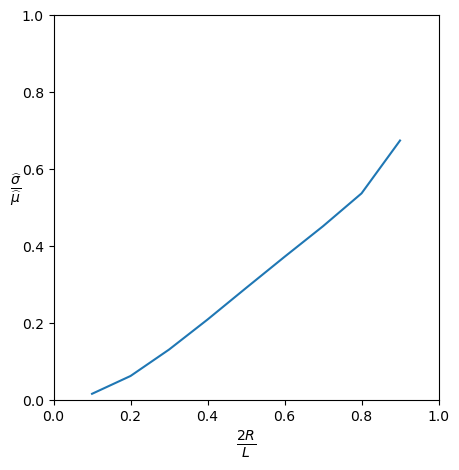

In [2]:
df = pd.read_excel('data/study_3.xlsx', sheet_name=['study_3_results'])

fig, ax = plt.subplots()

labels = {'study_3_results': '$L=L_0$'}
for k, v in labels.items():
    line, = ax.plot(df[k]['relative_radius'], df[k]['current_std'])
#     line.set_label(v)
# ax.legend();
ax.set_xlabel(r'$\frac{2R}{L}$', fontdict={'fontsize': 'x-large'});
ax.set_ylabel(r'$\frac{\widehat{\sigma}}{\widehat{\mu}}$', fontdict={'fontsize': 'x-large'}, rotation=0);
ax.set_xlim([0, 1]);
ax.set_ylim([0, 1]);
ax.set_box_aspect(1);
plt.tight_layout();
plt.savefig('figures/relative-size-features.png', dpi=1200);

### Current Density vs Angle

In [3]:
L = 1e-3

def get_angle(coord, radius):
    
    r = np.linalg.norm(coord[:-1] - 0.5 * L, 2)
    if not np.isclose(r/radius, 1):
        return np.nan
    
    if coord[1] < 0.5 * L:
        return np.nan

    adjacent = 0.5 * L - coord[0]
    return np.arccos(adjacent / radius)

In [4]:
def get_circle_coords(linemesh):
    coords = linemesh['/data0']
    lines = linemesh['/data1']
    markers = linemesh['/data2']
    line_coords = np.where(np.isclose(markers, 2))

    return np.unique(lines[line_coords])

In [5]:
def get_angular_values(rscale):
    R = rscale * 0.5 * L
    linemesh = h5py.File(f'data/study_3/{rscale}/line.h5', 'r')
    data = h5py.File(f'data/study_3/{rscale}/current.h5', 'r')
    coords = data['/Mesh/Grid/geometry']

    values = data['/Function/f/0']
    (coords.shape, values.shape, np.unique(coords[:, 2]))

    angles = []
    angles_values = []
    coords2 = get_circle_coords(linemesh)

    for i in range(coords.shape[0]):
        angle = get_angle(coords[i, :], radius=R)
        if np.isnan(angle):
            continue

        angles.append(angle)
        angles_values.append(values[i])
    
    angles = np.array(angles).reshape(-1, 1)
    angles_values = np.array(angles_values).reshape(-1, 1)
    arr = np.hstack((angles, angles_values))
    arr = np.take_along_axis(arr, np.argsort(arr, axis=0), axis=0)

    return arr

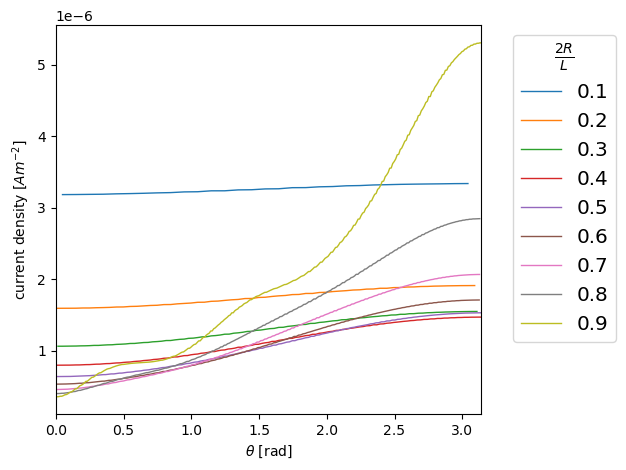

In [7]:
fig, ax = plt.subplots()
for rscale in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    arr = get_angular_values(rscale)
    line, = ax.plot(arr[:, 0], arr[:, 1], linewidth=1);
    line.set_label(f"{rscale}");
ax.set_xlabel(r'$\theta$ [rad]');
ax.set_ylabel('current density [$Am^{-2}$]');
ax.set_xlim([0, np.pi]);
ax.legend(title=r'$\frac{2R}{L}$', bbox_to_anchor=(1.05, 1.0), title_fontsize='x-large', fontsize='x-large');
plt.tight_layout();
plt.savefig('figures/relative-size-features-angular.png', dpi=1200);

## Apparent Effective Conductivity

In [ ]:
df = pd.read_excel('data/study_4.xlsx', sheet_name=['L0', 'L1', 'L2'])

fig, ax = plt.subplots()

labels = {'L0': '$L=L_0$', 'L1': '$L = 0.25 L_0$', 'L2': '$L=4L_0$'}
for k, v in labels.items():
    line, = ax.plot(df[k]['area_fraction'], df[k]['effective_conductivity'])
    line.set_label(v)
ax.legend();
ax.set_xlabel(r'$\frac{A}{A_0}$', fontdict={'fontsize': 'x-large'});
ax.set_ylabel(r'$\frac{\kappa_{eff}}{\kappa_{bulk}}$', fontdict={'fontsize': 'x-large'});
ax.set_xlim([0, 1]);
ax.set_ylim([0, 1]);
ax.set_box_aspect(1);
plt.tight_layout();
plt.savefig('figures/effective-conductivity-partial-area.png', dpi=1200);

## Contact Area Distributed

In [ ]:
df = pd.read_csv('data/contact-area-distributed.csv')
fig, ax = plt.subplots()
ax.semilogx(df['n_pieces'], df['resistance [Ohm]'])
ax.set_xlabel('$n_{pieces}$', fontdict={'size': 'x-large'});
ax.set_ylabel('Resistance $[\Omega]$', fontdict={'size': 'x-large'});
ax.set_title('$\kappa$ = 1 $Sm^{-1}$')
plt.tight_layout();
plt.savefig('figures/contact-area-distributed-semilog.png', dpi=1200);

In [ ]:
df = pd.read_excel('data/contact-area-distributed.xlsx', sheet_name=['data'])


In [ ]:
fig, ax = plt.subplots()
colors = ['tab:red', 'tab:blue']
line1, = ax.plot(df['data']['n_pieces'], df['data']['effective_conductivity'], 'o--', color=colors[1])
line1.set_label('conductivity')
ax.set_xlabel(r'$n_{pieces}$', fontdict={'fontsize': 'x-large'});
ax.set_ylabel(r'$\frac{\kappa_{eff}}{\kappa_{bulk}}$', fontdict={'fontsize': 'x-large'});
ax.set_title(r'$\frac{A}{A_0} = 0.5$', fontdict={'fontsize': 'x-large'})
ax2 = ax.twinx()
line2, = ax2.plot(df['data']['n_pieces'], 100 * df['data']['converge_error'], 'o--', color=colors[0]);
line2.set_label('% error')
ax2.set_ylabel('%');
ax.tick_params(axis='y', labelcolor=colors[1])
ax2.tick_params(axis='y', labelcolor=colors[0])
ax.set_ylim([0, 1]);
ax2.set_ylim([0, 100]);
ax.legend();
ax.legend(bbox_to_anchor=(1.15, 1.0), loc='upper left');
ax2.legend(bbox_to_anchor=(1.15, 0.9), loc='upper left');
ax.grid(True, which='both');
ax.minorticks_on()
plt.tight_layout();
plt.savefig('figures/contact-area-distributed-conductivity.png', dpi=1200);

In [ ]:
data = h5py.